In [1]:
import deepchem as dc
from deepchem.models import GraphConvModel
import numpy as np
import sys
import pandas as pd
import seaborn as sns
from rdkit.Chem import PandasTools
from tqdm.auto import tqdm

c:\Users\predator\anaconda3\envs\polar_duckdb_benchmarks\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def generate_graph_conv_model():
    batch_size = 128
    model = GraphConvModel(1, batch_size=batch_size, mode='classification', model_dir="./model_dir")
    return model

In [3]:
dataset_file = "dude_erk1_mk01.csv"
tasks = ["is_active"]
featurizer = dc.feat.ConvMolFeaturizer()
loader = dc.data.CSVLoader(tasks=tasks, feature_field="SMILES", featurizer=featurizer)
dataset = loader.create_dataset(dataset_file, shard_size=8192)

In [4]:
splitter = dc.splits.RandomSplitter()
metrics = [dc.metrics.Metric(dc.metrics.matthews_corrcoef, np.mean)]


In [5]:
training_score_list = []
validation_score_list = []
transformers = []
cv_folds = 10
for i in tqdm(range(0,cv_folds)):
    model = generate_graph_conv_model()
    train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(dataset)
    model.fit(train_dataset)
    train_scores = model.evaluate(train_dataset, metrics, transformers)
    training_score_list.append(train_scores["mean-matthews_corrcoef"])
    validation_scores = model.evaluate(valid_dataset, metrics, transformers)
    validation_score_list.append(validation_scores["mean-matthews_corrcoef"])
print(training_score_list)
print(validation_score_list)

100%|██████████| 10/10 [04:49<00:00, 28.90s/it]

[0.9595996558351719, 0.5924380262765028, 0.8325611058924068, 0.41829241657710053, 0.24411109159631952, 0.34541202665695525, 0.8208036433031983, 0.5048215863774402, 0.726672010332264, 0.9234043274855804]
[1.0, 0.531615869110444, 1.0, 0.0, 0.37550213752729766, 0.0, 0.4678118373451869, 0.5435391270264687, 0.813812201341186, 1.0]


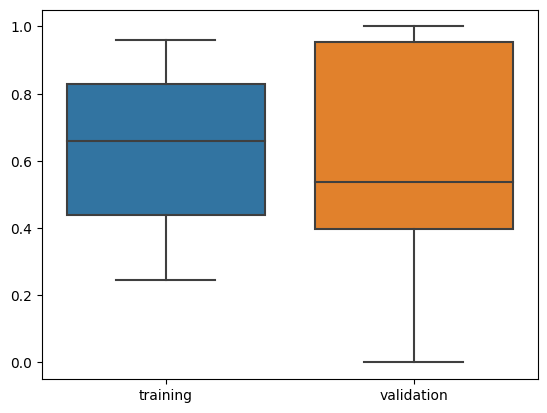

In [6]:
sns.boxplot(x=["training"]*cv_folds+["validation"]*cv_folds,y=training_score_list+validation_score_list);


In [7]:
pred = [x.flatten() for x in model.predict(valid_dataset)]
pred[:10]

[array([0.9944132 , 0.00558678], dtype=float32),
 array([9.9962842e-01, 3.7152725e-04], dtype=float32),
 array([0.99584085, 0.00415916], dtype=float32),
 array([9.9990797e-01, 9.1989416e-05], dtype=float32),
 array([9.9964082e-01, 3.5920631e-04], dtype=float32),
 array([9.9970335e-01, 2.9662548e-04], dtype=float32),
 array([9.9959248e-01, 4.0753448e-04], dtype=float32),
 array([0.9582773 , 0.04172266], dtype=float32),
 array([0.9972397 , 0.00276032], dtype=float32),
 array([0.9978654 , 0.00213459], dtype=float32)]

In [8]:
# put our predicted results into a Pandas dataframe.
pred_df = pd.DataFrame(pred,columns=["neg","pos"])
pred_df["active"] = [int(x) for x in valid_dataset.y]
pred_df["SMILES"] = valid_dataset.ids

In [9]:
pred_df.sort_values("pos",ascending=False).head(25)


,neg,pos,active,SMILES
40,0.036782,0.963218,1,c1cc(cc(c1)Cl)c2cn[nH]c2c3cc([nH]c3)C(=O)NC(CO...
415,0.049328,0.950672,1,c1cc(cc(c1)Cl)c2cn[nH]c2c3cc([nH]c3)C(=O)NC(CO...
60,0.061831,0.938169,1,c1cc(cc(c1)Cl)c2cn[nH]c2c3cc([nH]c3)C(=O)NCc4c...
23,0.103576,0.896424,1,Cc1ccccc1Nc2ncc(c(n2)c3cc([nH]c3)C(=O)N[C@H](C...
203,0.122877,0.877123,1,c1ccc(c(c1)C(CO)NC(=O)c2cc(c[nH]2)c3c(cn[nH]3)...
34,0.372575,0.627425,1,c1cc(cc(c1)Cl)c2cn[nH]c2c3cc([nH]c3)C(=O)N4CCCC4
327,0.834687,0.165313,0,c1ccc(cc1)c2c3ccccc3[nH]c(=O)c2Sc4[nH]ncn4
253,0.899184,0.100816,0,CC(C)CNC(=O)c1cccc(c1)NCc2c3ccccc3ccc2OCC(=O)N
354,0.926389,0.073611,0,CSc1cc(ccc1NC(=O)Nc2ccc(c(c2)C(F)(F)F)Cl)Oc3cc...
150,0.945535,0.054465,0,C[C@@H]1C[C@@H](C)CN(C(C)(C)CNC(=O)c2ccc3c(O)[...


<AxesSubplot:xlabel='active', ylabel='pos'>

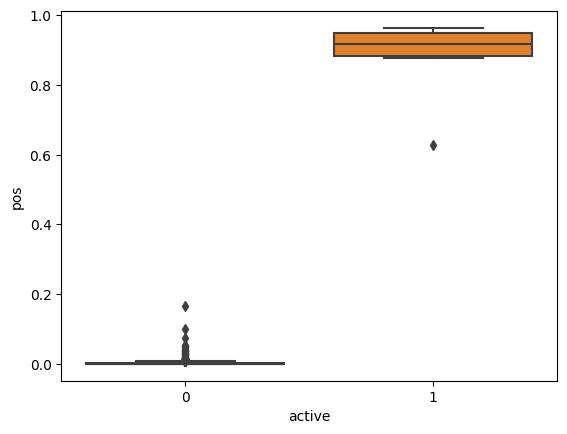

In [10]:
sns.boxplot(x=pred_df.active,y=pred_df.pos)